# Neural Modelling Exercise 5
Submitted by **Mohammed Abbas Ansari** and **Kai Rothe**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# define maze
maze = np.zeros((9, 13))

# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = (5, 7)

# define goal (we abuse function scoping a bit here, later we will change the goal, which will automatically change the goal in our actor critic as well)
goal = (1, 1)
goal_state = goal[0]*maze.shape[1] + goal[1]
goal_value = 10

In [3]:
def plot_maze(ax, maze, start=None, goal=None):
    ax.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        ax.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        ax.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)
    if start is not None:
        ax.scatter(start[1], start[0], color='blue', marker="*", s=100, label='start')
    if goal is not None:
        ax.scatter(goal[1], goal[0], color='green', marker="*", s=100, label='goal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='upper center', bbox_to_anchor=(1, 1))

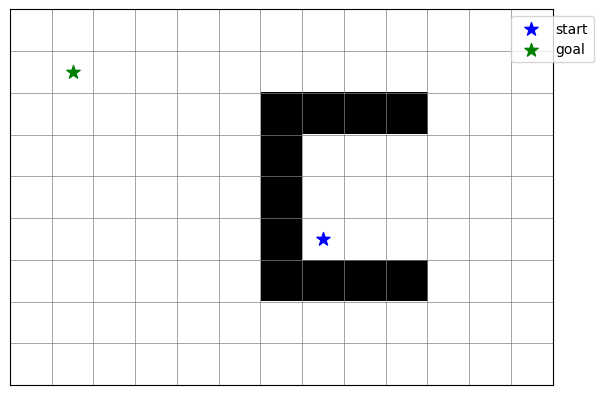

In [4]:
fig, ax = plt.subplots(1, figsize=(7, 7))
plot_maze(ax, maze, start=start, goal=goal)

In [5]:
def compute_transition_matrix(maze):
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    transitions = np.zeros((maze.size, maze.size))

    # iterate over all states, filling in the transition probabilities to all other states on the next step (only one step into the future)
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            # check if state is valid
            if maze[i, j] == 0:
                # iterate over all possible moves
                for move in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    new_i, new_j = i + move[0], j + move[1]
                    # check if new state is valid
                    if new_i >= 0 and new_i < maze.shape[0] and new_j >= 0 and new_j < maze.shape[1] and maze[new_i, new_j] == 0:
                        transitions[i*maze.shape[1] + j, new_i*maze.shape[1] + new_j] = 1
    
    # normalize transitions
    transitions /= transitions.sum(axis=1, keepdims=True);

    # remove NaNs
    transitions[np.isnan(transitions)] = 0

    return transitions

In [104]:
def compute_analytical_sr(transitions, gamma):
    return np.linalg.inv(np.eye(transitions.shape[0]) - gamma * transitions.T)

### Part 1: Actor-Critic Function

We implemented the algorithm **One-step Actor–Critic (episodic), for estimating $\pi_{\theta}$** from section 13.5 of Sutton & Barto. We use the following updates:
$$\delta = R + \gamma v(S', \textbf{w}) - v(S, \textbf{w})$$
$$\textbf{w} \leftarrow \textbf{w} + \alpha \delta X(S)$$
$$M(S) \leftarrow M(S) + \alpha \delta \nabla \ln \pi(A|S, M)$$
Where $\nabla \ln \pi(A|S, M)$ is calculated for different actions based on $\frac{\partial \ln \pi(a;M)}{\partial m_{j}} = 1 - \pi(a;M)$, if $a=j$; else $\frac{\partial \ln \pi(a;M)}{\partial m_{j}} = - \pi(a;M)$

We use Temporal difference error to learn the successor representation $X$ ([Vitay, 2019](https://julien-vitay.net/post/successor_representations/#ref-Gershman2012)):
$$\delta_{t}^{SR} = I(s_{t} = s') + \gamma^{SR} X(s_{t+1}, s') - X(s_t, s')$$ 
$$X(s_t, s') = X(s_t, s') + \alpha \delta_{t}^{SR}$$

In [7]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtract max(x) for numerical stability
    return exp_x / np.sum(exp_x, axis=0)

def normal_start():
    # suggested encoding of 2D location onto states
    state = start[0]*maze.shape[1] + start[1]
    return state

def random_start():
    state = np.random.choice(maze.shape[0]*maze.shape[1])
    while maze[np.unravel_index(state, maze.shape)] == 1 or state == goal_state:
        state = np.random.choice(maze.shape[0]*maze.shape[1])
    return state

def actor_critic(state_representation, n_steps, alpha, gamma, n_episodes, update_sr=False, gamma_sr=None, start_func=normal_start, v_init=0):
    # implement the actor-critic algorithm to learn to navigate the maze
    # state_representation is a matrix of size n_states by n_states, giving us the representation for each, which is either a 1-hot vector
    # # (so e.g. state_representation[15] is a vector of size n_states which is 0 everwhere, except 1 at index 15), or the SR for each state
    # n_steps is the number of actions in each episode before it gets cut off, an episode also ends when the agent reaches the goal
    # alpha and gamma are the learning rate and discount factor respectively
    # n_episodes is the number of episodes to train the agent
    # update_sr is for exercise part 3, when you want to update the SR after each episode
    # start_func allows you to specify a different starting state, if desired

    # initialize M-table
    M = np.zeros((len(state_representation), 4))
    
    # initialize state-value function
    V_weights = np.zeros(len(state_representation)) + v_init

    earned_rewards = []
    final_goal_path = None
    optimal_path_len = np.inf
    moves = [maze.shape[1], -maze.shape[1], 1, -1] # down, up, right, left
    
    def get_action_probs(state):
        action_probs = softmax(M[state])
        r, c = np.unravel_index(state, maze.shape)
        for i, (nr, nc) in enumerate([(r+1, c), (r-1, c), (r, c+1), (r, c-1)]):
            if not (nr >= 0 and nr < maze.shape[0] and nc >= 0 and nc < maze.shape[1] and maze[nr, nc] == 0):
                # set probability of invalid actions to 0
                action_probs[i] = 0 
        action_probs[np.isnan(action_probs)] = 0
        action_probs /= action_probs.sum()
        return action_probs

    # iterate over episodes
    for _ in range(n_episodes):
        # initializations
        cur_state = start_func()
        episode_reward = 0
        state_trajectory = [cur_state]

        # go until goal is reached
        for t in range(n_steps):
            # Sample a valid action and get next state
            action_probs = get_action_probs(cur_state)
            action = np.random.choice(4, p=action_probs)
            next_state = cur_state + moves[action] 
                   
            reward = goal_value if np.unravel_index(next_state, maze.shape) == goal else 0
            episode_reward += np.pow(gamma,t)*reward
                
            # update V_weights
            V_cur = np.dot(state_representation[cur_state], V_weights)
            V_next = np.dot(state_representation[next_state], V_weights)
            
            td_error = reward + (gamma*V_next*(int(reward != goal_value))) - V_cur # V_next is 0 if goal is reached
            
            V_weights += alpha * td_error * state_representation[cur_state] # dV(s, w)/dw = X(s)
            
            # update M
            log_gradient = -action_probs    # dPi_m(a'|s)/dm = - Pi_m(a'|s) for all a' != a
            log_gradient[action] += 1       # dPi_m(a'|s)/dm = Pi_m(a'|s) - 1 for a' = a
            M[cur_state] += alpha * np.pow(gamma, t) * td_error * log_gradient
            
            # Update SR
            if update_sr:
                sr_td_error = gamma_sr * state_representation[next_state] - state_representation[cur_state]
                sr_td_error[cur_state] += 1
                state_representation[cur_state] += alpha * sr_td_error
                
            # update current state
            cur_state = next_state
            state_trajectory.append(cur_state)
            
            # check if goal is reached
            if np.unravel_index(cur_state, maze.shape) == goal:
                if t < optimal_path_len:
                    final_goal_path = state_trajectory
                    optimal_path_len = t+1
                if update_sr:
                    sr_td_error = - state_representation[cur_state] # goal state is terminal, thus no successor states
                    sr_td_error[cur_state] += 1
                    state_representation[cur_state] += alpha * sr_td_error
                break
                
        earned_rewards.append(episode_reward)
            
    return M, V_weights, earned_rewards, final_goal_path, state_representation

In [8]:
def plot_values_and_reward_evolution(plot_tile, V_weights, V, earned_rewards, final_goal_path, show_path=False, show_values=False, start_state=None, show_max_reward=False):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    
    plot_maze(ax[0], maze, start=start_state, goal=goal)
    ax[0].imshow(V_weights.reshape((maze.shape[0], maze.shape[1])), aspect='auto', cmap='hot')
    for (i,j), label in np.ndenumerate(V_weights.reshape((maze.shape[0], maze.shape[1]))):
        if show_values:
            ax[0].text(j, i, round(label, 2), ha='center', va='center', color='green',)
    ax[0].set_title('V weights')
    
    plot_maze(ax[1], maze, start=start_state, goal=goal)
    ax[1].imshow(V.reshape((maze.shape[0], maze.shape[1])), aspect='auto', cmap='hot')
    for (i,j), label in np.ndenumerate(V.reshape((maze.shape[0], maze.shape[1]))):
        if show_values:
            ax[1].text(j, i, round(label, 2), ha='center', va='center', color='green')
    if show_path:
        pos_trajectory = [np.unravel_index(state, maze.shape) for state in final_goal_path]
        ax[1].plot([pos[1] for pos in pos_trajectory], [pos[0] for pos in pos_trajectory], color='green', lw=2, label='Path', alpha=0.8)
       
    ax[1].set_title('V')
        
    ax[2].plot(earned_rewards)
    if show_max_reward:
        max_reward = goal_value * (gamma ** (len(final_goal_path)-2))
        ax[2].axhline(max_reward, color='green', linestyle='--', label='Max possible reward')
    ax[2].set_title('Reward Evolution')
    ax[2].set_xlabel('Episode')
    ax[2].set_ylabel('Discounted Reward')
    
    fig.suptitle(plot_tile, fontsize=14)
    plt.show()

In [218]:
n_steps = 300
alpha = 0.05
gamma = 0.99
n_episodes = 1000
gamma_sr = 0.8
goal = (1, 1)
goal_state = goal[0]*maze.shape[1] + goal[1]
goal_value = 10

In [219]:
state_representation = np.eye(maze.size)
M, V_weights, earned_rewards, final_goal_path, _ = actor_critic(state_representation=state_representation, 
                                                                n_steps=n_steps, 
                                                                alpha=alpha, 
                                                                gamma=gamma, 
                                                                n_episodes=n_episodes)

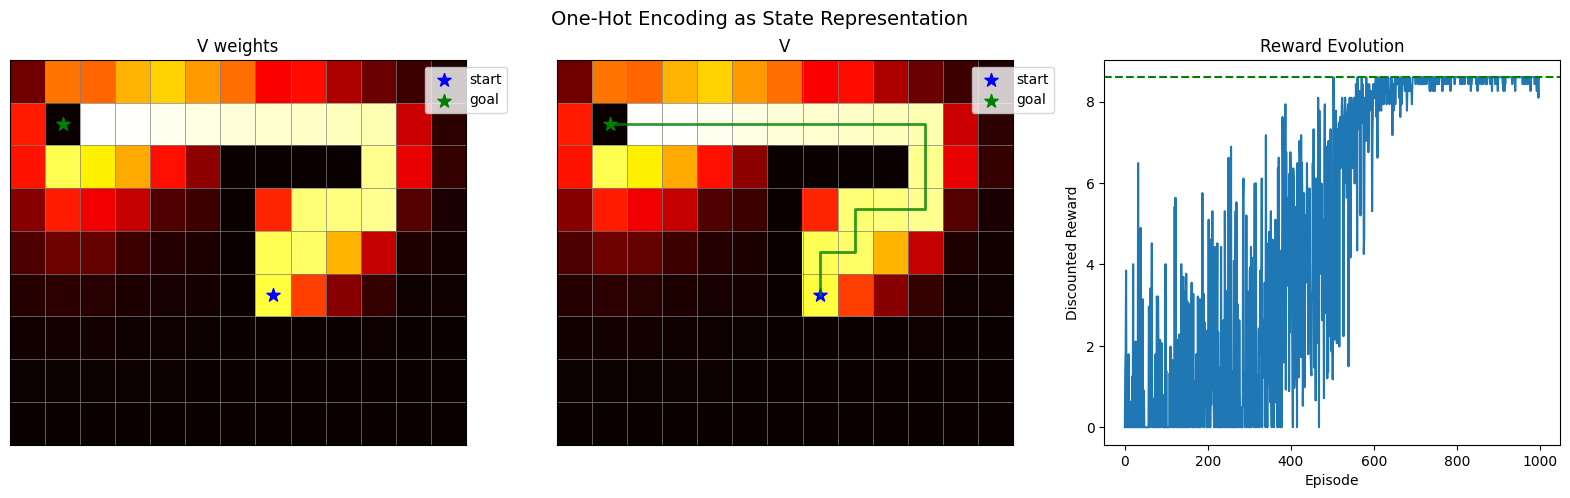

In [220]:
plot_values_and_reward_evolution("One-Hot Encoding as State Representation", V_weights, state_representation @ V_weights, earned_rewards, final_goal_path, show_path=True, show_values=False, start_state=start, show_max_reward=True)

In the One-Hot encoding case, V_weights and V are identical. The value function shows position / states along the shortest path have higher values (towards white) than other states (towards red / black). There is an ascending gradient of values along the shortest path due to discounting of future value. Since the goal is absorbing, the goal state shows zero rewards and a state before the rewarding transition to goal shows the highest value.

The learning curves shows the actor-critic converges to the optimal solution (earned reward for shortest path from start to goal of 16 steps, smaller than the goal value of 10 due to the discounting) after around 700 epsiodes, with an example path shown in green above. 

#### Part 2: Actor-Critic with Analytical SR as State Representation

In [227]:
transitions = compute_transition_matrix(maze)
analytical_sr = compute_analytical_sr(transitions, 0.8)

/var/folders/yf/pf3_bqj55n55b17z1ydbr5dc0000gn/T/ipykernel_32562/3771992233.py:21: RuntimeWarning: invalid value encountered in divide
  transitions /= transitions.sum(axis=1, keepdims=True);


In [228]:
M, V_weights, earned_rewards, final_goal_path, _ = actor_critic(state_representation=analytical_sr,
                                                                n_steps=n_steps, 
                                                                alpha=alpha, 
                                                                gamma=gamma, 
                                                                n_episodes=n_episodes)

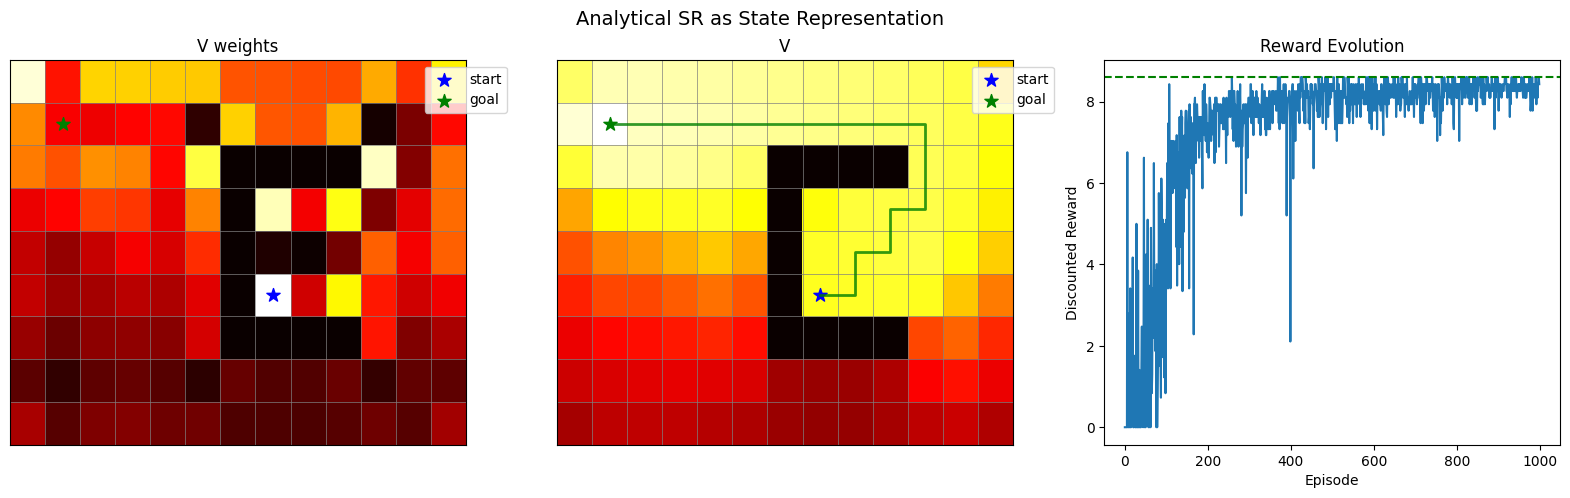

In [229]:
plot_values_and_reward_evolution("Analytical SR as State Representation", V_weights, analytical_sr @ V_weights, earned_rewards, final_goal_path, show_path=True, show_values=False, start_state=start, show_max_reward=True)

With SR as state representation, V_weights is not identical to V. The learned value function shows regions around the goal and towards the start state have higher rewards compared to other regions. The goal state itself has the highest value which is propogated backwards with discounting towards the start state. 

The learning curve shows faster learning, i.e. convergence to the optimal solution, for using the successor representation compared to using the one-hot representation from part 1. The value function shows why: after finding the goal once, due to the successor representation, the critic can correctly learn values of never visited states after propagating the goal value back, leading to higher values even of seldomly visited states compared to part 1.

### Part 3: Actor-Critic with Re-Learned SR as State Representation & Random Starts

In [108]:
def plot_SR(title, learned_sr, analytical_sr, positions, show_values=False):
    fig, axs = plt.subplots(2, len(positions), figsize=(20, 6))
    # plot_maze(maze)
    for k, (y, x) in enumerate(positions):
        axs[0][k].scatter(x, y, marker='*', color='blue', s=100)
        axs[1][k].scatter(x, y, marker='*', color='blue', s=100)
        pos = y*maze.shape[1] + x
        axs[0][k].imshow(learned_sr[pos].reshape((maze.shape[0], maze.shape[1])), cmap='hot')
        axs[0][k].set_title('Re-Learned SR at ({}, {})'.format(y, x))
        axs[1][k].imshow(analytical_sr[pos].reshape((maze.shape[0], maze.shape[1])), cmap='hot')
        axs[1][k].set_title('Analytical SR at ({}, {})'.format(y, x))
        for (i,j), label in np.ndenumerate(learned_sr[pos].reshape((maze.shape[0], maze.shape[1]))):
            if show_values:
                axs[0][k].text(j, i, round(label, 2), ha='center', va='center', color='green', fontsize=6)
    fig.suptitle(title, fontsize=15);

In [247]:
state_representation = compute_analytical_sr(transitions, 0.8) # initialize SR with analytical SR with random walk policy
M, V_weights, earned_rewards, final_goal_path, learned_SR = actor_critic(state_representation=state_representation, 
                                                                        n_steps=n_steps, 
                                                                        alpha=alpha, 
                                                                        gamma=gamma, 
                                                                        n_episodes=n_episodes, 
                                                                        update_sr=True, 
                                                                        gamma_sr=gamma_sr,
                                                                        start_func=random_start)

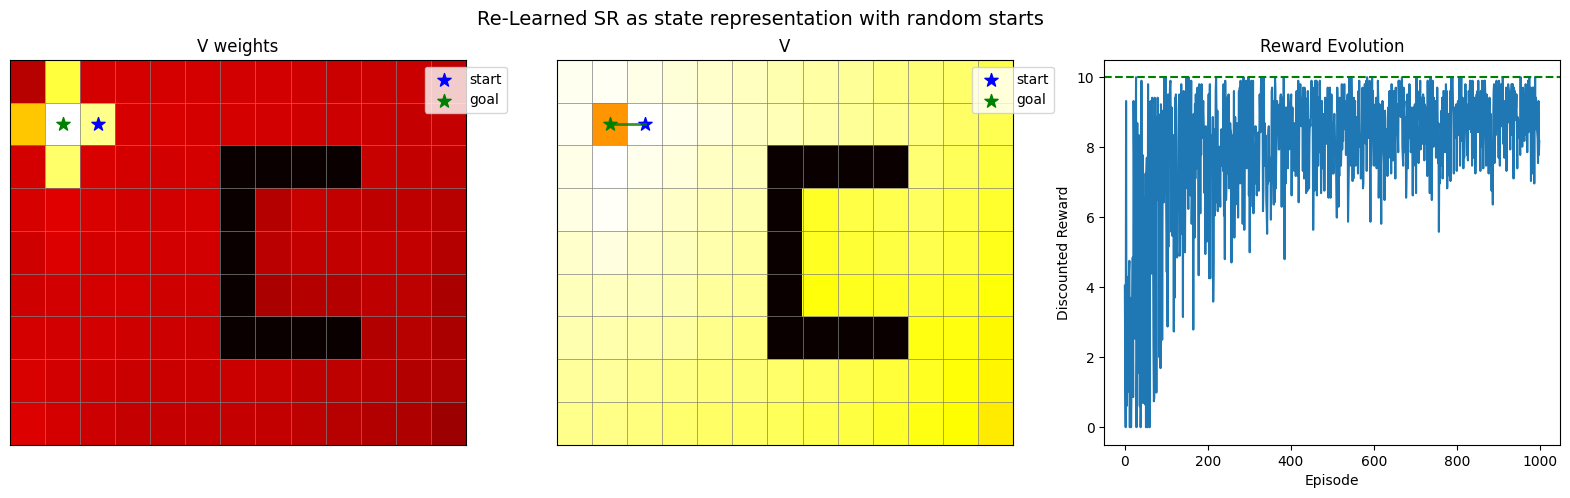

In [248]:
plot_values_and_reward_evolution("Re-Learned SR as state representation with random starts", V_weights, learned_SR @ V_weights, earned_rewards, final_goal_path, show_path=True, show_values=False, start_state=np.unravel_index(final_goal_path[0], maze.shape), show_max_reward=True)

With random starts, the values are propogated backwards from goal state to all possible start states with discounting based on shortest paths, thus the closer states have higer values than states further away. 

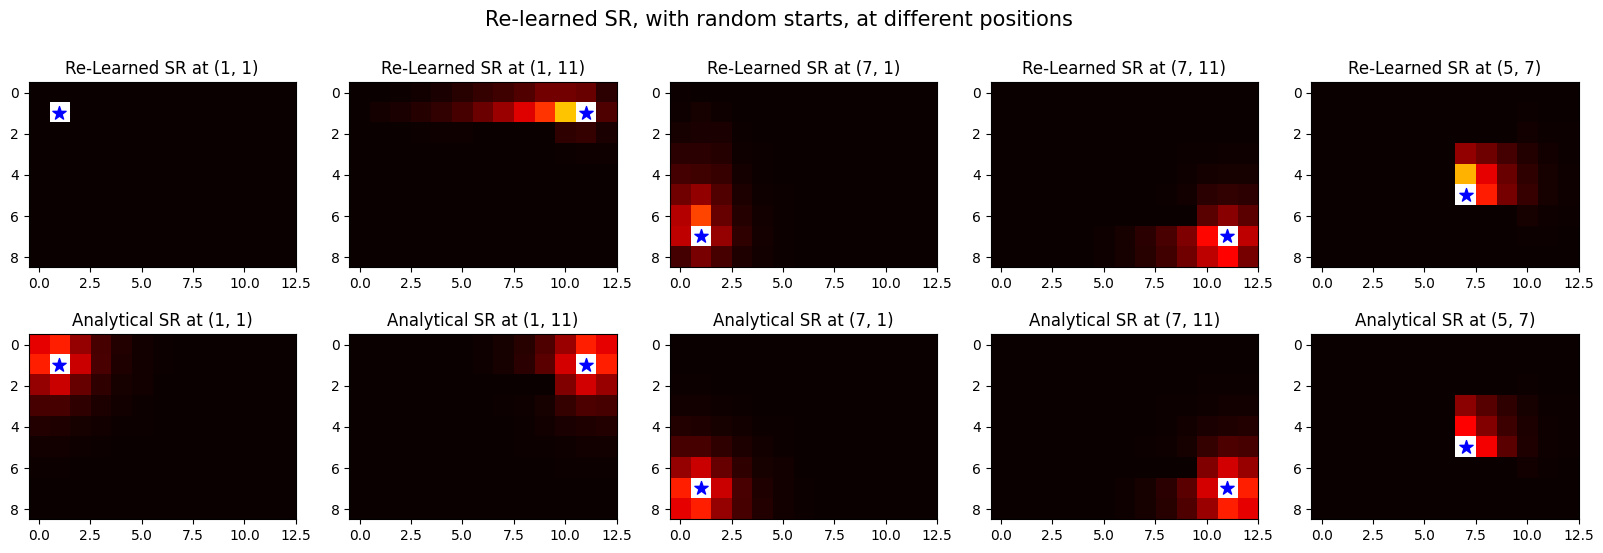

In [244]:
positions = [(1,1), (1, 11), (7, 1), (7, 11), (5, 7)]
plot_SR("Re-learned SR, with random starts, at different positions", learned_SR, analytical_sr, positions, show_values=False)

Compared to the successor representation of a random walk, the learned successor repressentation shows a higher occupation of states closer to the goal / along the path to the goal, since those states are more likely to be visited while learning a policy for finding a goal at (1,1).

The learned successor representation of goal state shows that it is an absorbing terminal state, thus there can't be any other states that can be occupied in the future.

### Part 4: Comparing Actor-Critic with Analytical and Re-Learned SR for State Representation with Goal at new location

In [201]:
# Re-learning SR for goal at (1,1) with different gamma values
goal = (1,1)
goal_state = goal[0]*maze.shape[1] + goal[1]
gamma_sr_values = [0.1, 0.5, 0.8, 0.9, 0.99]
learned_SR = []
for gamma_sr in gamma_sr_values:
    state_representation = compute_analytical_sr(transitions, 0.8) # initialize SR with analytical SR with random walk policy
    sr = actor_critic(state_representation=state_representation, n_steps=n_steps, alpha=alpha, gamma=gamma, n_episodes=n_episodes, update_sr=True, gamma_sr=gamma_sr,start_func=random_start)[-1]
    learned_SR.append(sr)

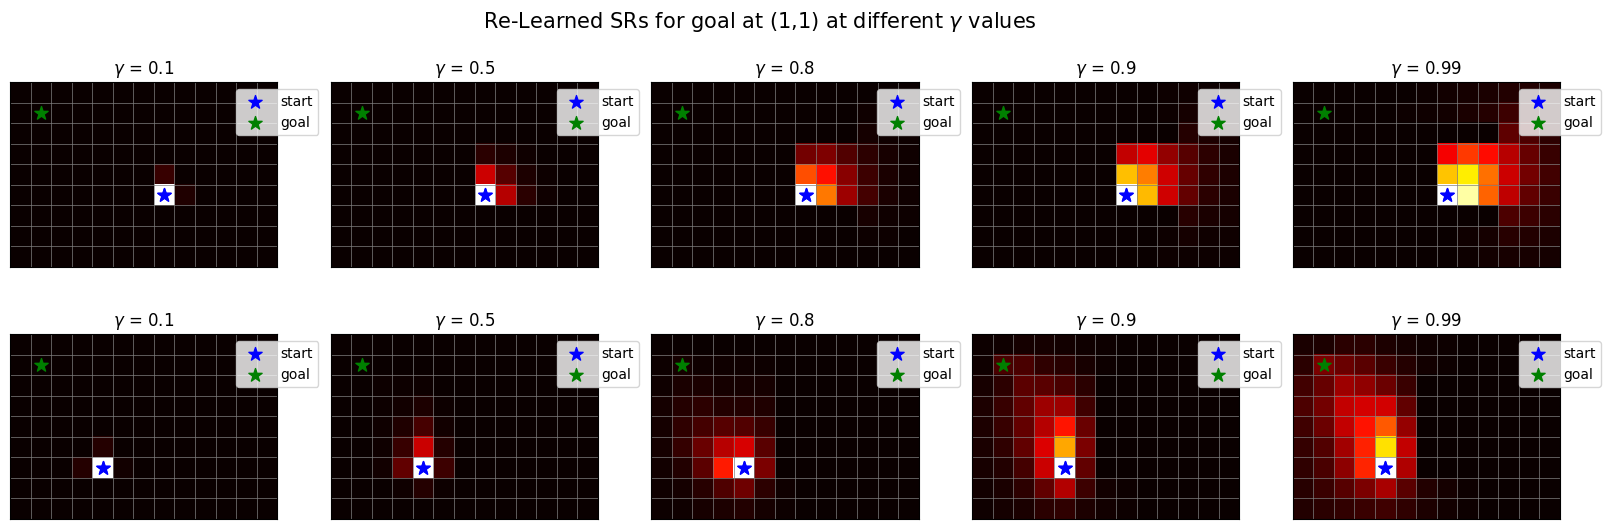

In [216]:
# plot different learned SRs
positions = [start, (6,4)]
fig, axs = plt.subplots(len(positions), len(gamma_sr_values), figsize=(20, 6))

for i, position in enumerate(positions):
    for j, sr in enumerate(learned_SR):
        plot_maze(axs[i][j], maze, start=position, goal=goal)
        axs[i][j].scatter(position[1], position[0], marker='*', color='blue', s=100)
        state = position[0]*maze.shape[1] + position[1]
        axs[i][j].imshow(sr[state].reshape((maze.shape[0], maze.shape[1])), cmap='hot')
        axs[i][j].set_title(r'$\gamma$ = {}'.format(gamma_sr_values[j]))

fig.suptitle("Re-Learned SRs for goal at (1,1) at different $\gamma$ values", fontsize=15);

We show the effect of the temporal discounting factor $\gamma_{sr}$ for learning the sucessor representation. With smaller $\gamma_{sr}$ values, SR is more local, while for larger values, SR extends much further from intial state. All of the SRs are biased towards the goal state since these are learned while learning a policy for finding a goal at (1,1).

This plot helps explain the subsequent learning curves where for smaller $\gamma_{sr}$ values, learning is much slower due to slow propogation of values because of very local nature of these SRs.

In [139]:
goal = (5,5)
goal_state = goal[0]*maze.shape[1] + goal[1]
num_runs = 20
analytical_sr_rewards = np.zeros((num_runs, n_episodes))
learned_sr_rewards = np.zeros((len(gamma_sr_values), num_runs, n_episodes))

for i in tqdm(range(num_runs)):
    analytical_sr_rewards[i] = np.array(actor_critic(state_representation=analytical_sr, n_steps=n_steps, alpha=alpha, gamma=gamma, n_episodes=n_episodes)[2])
    for j, sr in enumerate(learned_SR):
        learned_sr_rewards[j][i] = np.array(actor_critic(state_representation=sr, n_steps=n_steps, alpha=alpha, gamma=gamma, n_episodes=n_episodes)[2])

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


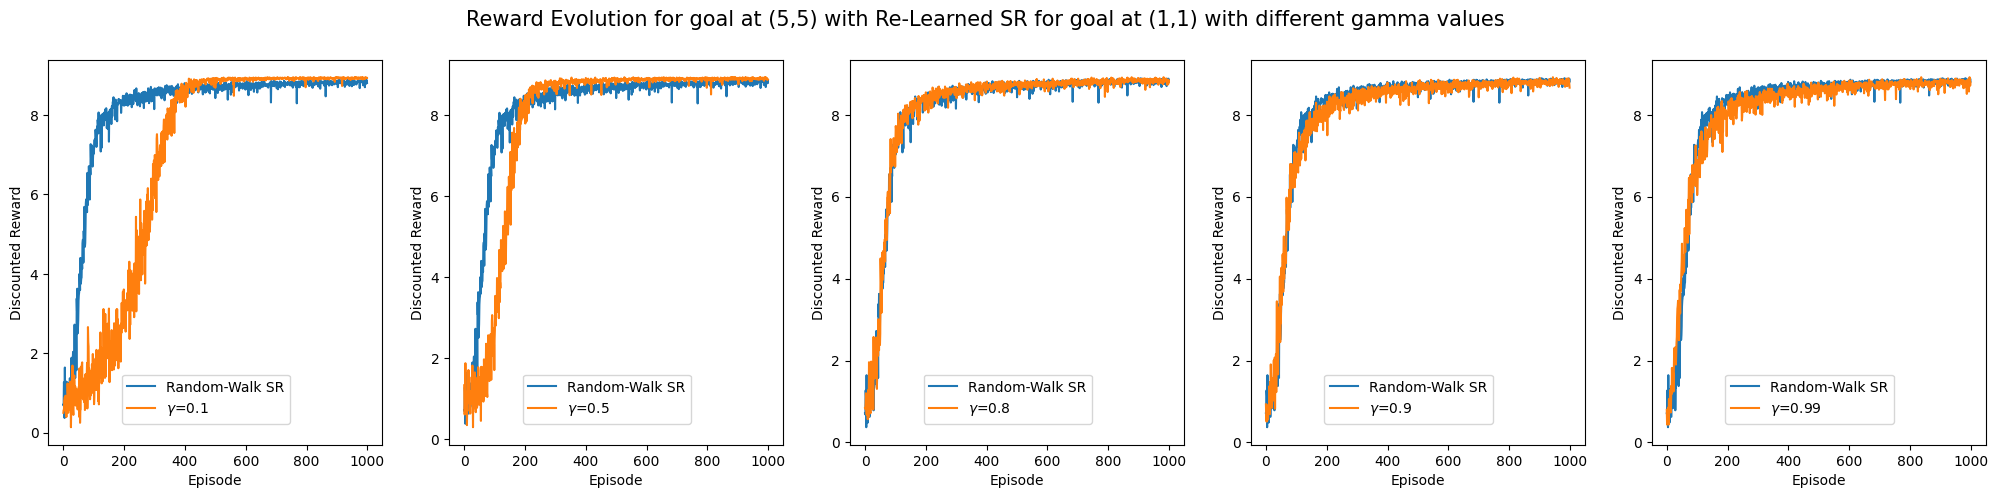

In [189]:
# Plot mean across runs
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, gamma_sr in enumerate(gamma_sr_values):
    axs[i].plot(np.mean(analytical_sr_rewards, axis=0), label='Random-Walk SR')
    axs[i].plot(np.mean(learned_sr_rewards[i], axis=0), label=r"$\gamma$={}".format(gamma_sr))
    axs[i].set_xlabel('Episode')
    axs[i].set_ylabel('Discounted Reward')
    axs[i].legend(bbox_to_anchor=(0.2, 0.2))
fig.suptitle('Reward Evolution for goal at (5,5) with Re-Learned SR for goal at (1,1) with different gamma values', fontsize=15)    
plt.show()

- Smaller $\gamma_{sr}$ values shows slower convergence due to reason explained above. $\gamma_{sr}=0$ would correspond to case of one-hot encoding representation.

- For $\gamma_{sr}$ values close to 0.8, which is the discounting factor used to calculate the random-walk SR, we observe little to no difference between the curves. 

- For $\gamma_{sr} = 0.99$, we observe two things: 
    1. Learning happens quicker initially with learned-SR compared to random-walk SR. This can be explained by the idea that the learned SR biases the agent to move out from the well formed by the walls, thus can reach the goal much more quickly when compared to a random-walk SR.
    2. Eventually learning with random-walk SR catches up and exceeds the learned-SR. At this point, the learned-SR is biased towards goal at (1,1), thus accurate value propogation from goal state takes longer to propogate back to initial state, thus takes longer to find the shortest path.

#### Part 5: Effect of Initializations

In [142]:
state_representation = np.eye(maze.size)
analytical_sr = compute_analytical_sr(transitions, 0.8).T

In [53]:
intializations = [np.ones(len(state_representation))*k for k in [0, 1, 4, 7, 10, 20, 40, 80]]
goal = (1,1)
goal_state = goal[0]*maze.shape[1] + goal[1]
goal_value = 10
earned_mean_rewards_punctuate = []
earned_mean_rewards_sr = []
num_runs = 20
for init in tqdm(intializations):
    earned_rewards_punctuate = []
    earned_rewards_sr = []
    for _ in range(num_runs):
        _, _, puntuate_rewards, _, _ = actor_critic(state_representation=state_representation, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=1000, v_init=init)
        _, _, sr_rewards,_, _ = actor_critic(state_representation=analytical_sr, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=1000, v_init=init)
        earned_rewards_punctuate.append(puntuate_rewards)
        earned_rewards_sr.append(sr_rewards)
    earned_mean_rewards_punctuate.append(np.array(earned_rewards_punctuate).mean(axis=0))
    earned_mean_rewards_sr.append(np.array(earned_rewards_sr).mean(axis=0))

100%|██████████| 8/8 [23:03<00:00, 172.95s/it]


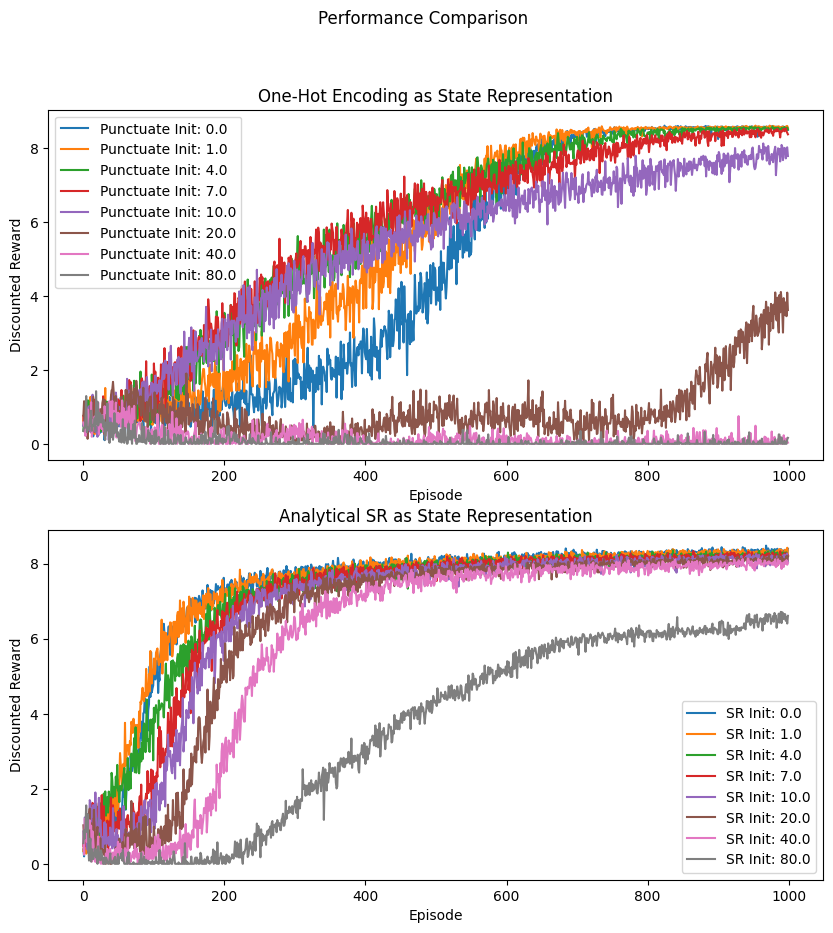

In [54]:
# plot the different initialization
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

for i, init in enumerate(intializations):
    axs[0].plot(earned_mean_rewards_punctuate[i], label='Punctuate Init: {}'.format(init[0]))
    axs[0].legend()
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Discounted Reward')
    axs[0].set_title('One-Hot Encoding as State Representation')
    axs[1].plot(earned_mean_rewards_sr[i], label='SR Init: {}'.format(init[0])) 
    axs[1].legend()
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Discounted Reward')
    axs[1].set_title('Analytical SR as State Representation')
fig.suptitle('Performance Comparison');

Policy learning happens faster with analytical SR as compared to one-hot encoding as state representation for all initializations for same reasons explained in part 2.

Using one-hot encoding as state representation means that V_weights are identical to V. Thus we are directly learning and updating the value function at each step when we update V_weights. Therefore, we are directly intializing the value at each state with different weight initializations. While learning, the actor-critic algorithm has to propogate a reward value of 10 from goal state towards the initial state with discounting. Thus the final learned value function has discounted values of 10 from start state to goal state. 
- If we initialize the values of states greater than 0 and less than equal to 10, then it would mean that there would be lesser updates required for the states along the path from start to goal state. This can observed in the learning curves for initialization values 1,4,7 and 10 which are much faster than 0 initialization. 
- With weight initialization as 10, we observe that learning is fast for 600 episodes and then subsequently slower since in those steps non-optimal states value have to be reduced which can take more steps.
- With any weight initialization larger than 10, no or very little learning happens since the agent may never seek the goal state which only gives a reward value of 10 while all other states have a value of larger than 10. It might take more than 1000 episodes to observe some learning or convergence.

Using successor representation as state representation, V_weights essentially are used to weight the future expected occupancies for current state to obtain the expected value V. $$ V = SR(s) \cdot w $$
For non-zero weight initializations, there is a larger value function for all the states compared to zero intialization. Larger weight initializations might help initially, as observed by faster learning for first 50 episodes, to move towards the goal, but ultimately the incorrect large values for states not in path from start to goal need to be decremented which can take longer for very large intializations. Most of the initializations still converge due to fast learning with SR, except with 80 initialization which might take longer than 1000 episodes.

In [58]:
goal_value = 5
intializations = [np.ones(len(state_representation))*k for k in [0, 1, 4, 7, 10, 20, 40, 80]]

earned_mean_rewards_punctuate = []
earned_mean_rewards_sr = []
num_runs = 20
for init in tqdm(intializations):
    earned_rewards_punctuate = []
    earned_rewards_sr = []
    for _ in range(num_runs):
        _, _, puntuate_rewards, _,, _  = actor_critic(state_representation=state_representation, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=1000, v_init=init)
        _, _, sr_rewards, _, _ = actor_critic(state_representation=analytical_sr, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=1000, v_init=init)
        earned_rewards_punctuate.append(puntuate_rewards)
        earned_rewards_sr.append(sr_rewards)
    earned_mean_rewards_punctuate.append(np.array(earned_rewards_punctuate).mean(axis=0))
    earned_mean_rewards_sr.append(np.array(earned_rewards_sr).mean(axis=0))

100%|██████████| 8/8 [29:18<00:00, 219.78s/it]


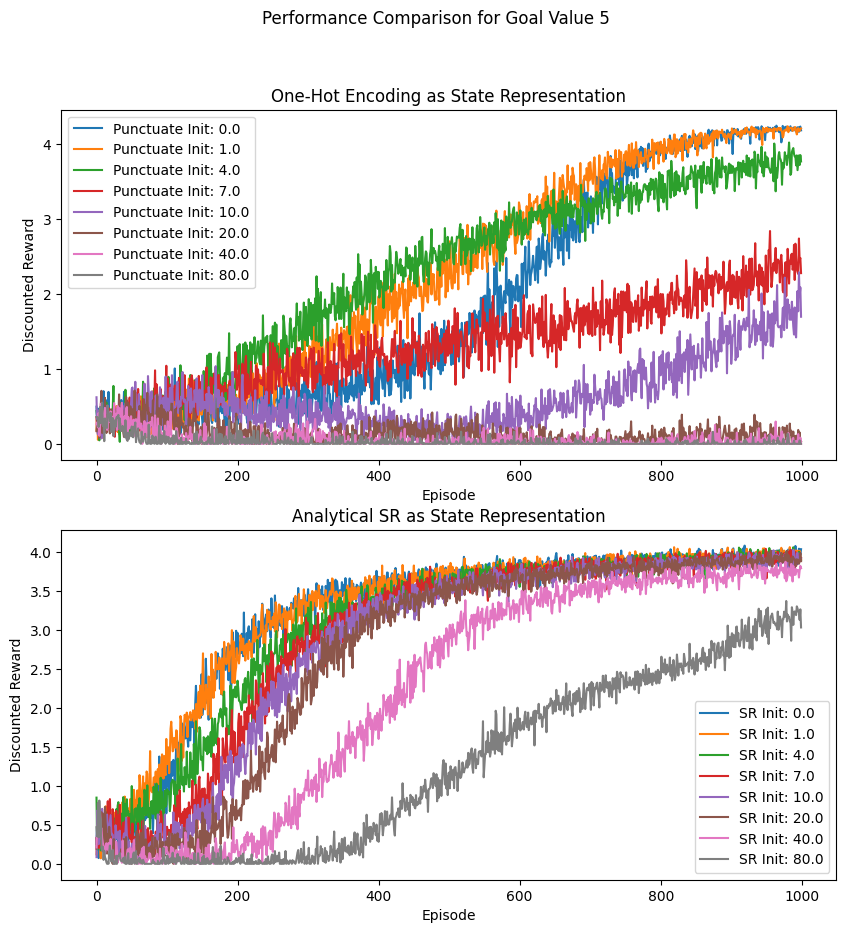

In [59]:
# plot the different initialization
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

for i, init in enumerate(intializations):
    axs[0].plot(earned_mean_rewards_punctuate[i], label='Punctuate Init: {}'.format(init[0]))
    axs[0].legend()
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Discounted Reward')
    axs[0].set_title('One-Hot Encoding as State Representation')
    axs[1].plot(earned_mean_rewards_sr[i], label='SR Init: {}'.format(init[0])) 
    axs[1].legend()
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Discounted Reward')
    axs[1].set_title('Analytical SR as State Representation')
fig.suptitle('Performance Comparison for Goal Value 5');

To confirm the observation that the different learning curves for initialization depend on the value of the reward at goal state, we ran the code with a goal value as 5. We can clearly see in One-hot encoding case that initializations smaller than 5 have faster learning while intializations larger than 5 have worser learning.

In [60]:
goal_value = 20
intializations = [np.ones(len(state_representation))*k for k in [0, 1, 4, 7, 10, 20, 40, 80]]

earned_mean_rewards_punctuate = []
earned_mean_rewards_sr = []
num_runs = 20
for init in tqdm(intializations):
    earned_rewards_punctuate = []
    earned_rewards_sr = []
    for _ in range(num_runs):
        _, _, puntuate_rewards, _, _ = actor_critic(state_representation=state_representation, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=1000, v_init=init)
        _, _, sr_rewards, _, _ = actor_critic(state_representation=analytical_sr, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=1000, v_init=init)
        earned_rewards_punctuate.append(puntuate_rewards)
        earned_rewards_sr.append(sr_rewards)
    earned_mean_rewards_punctuate.append(np.array(earned_rewards_punctuate).mean(axis=0))
    earned_mean_rewards_sr.append(np.array(earned_rewards_sr).mean(axis=0))

100%|██████████| 8/8 [16:54<00:00, 126.87s/it]


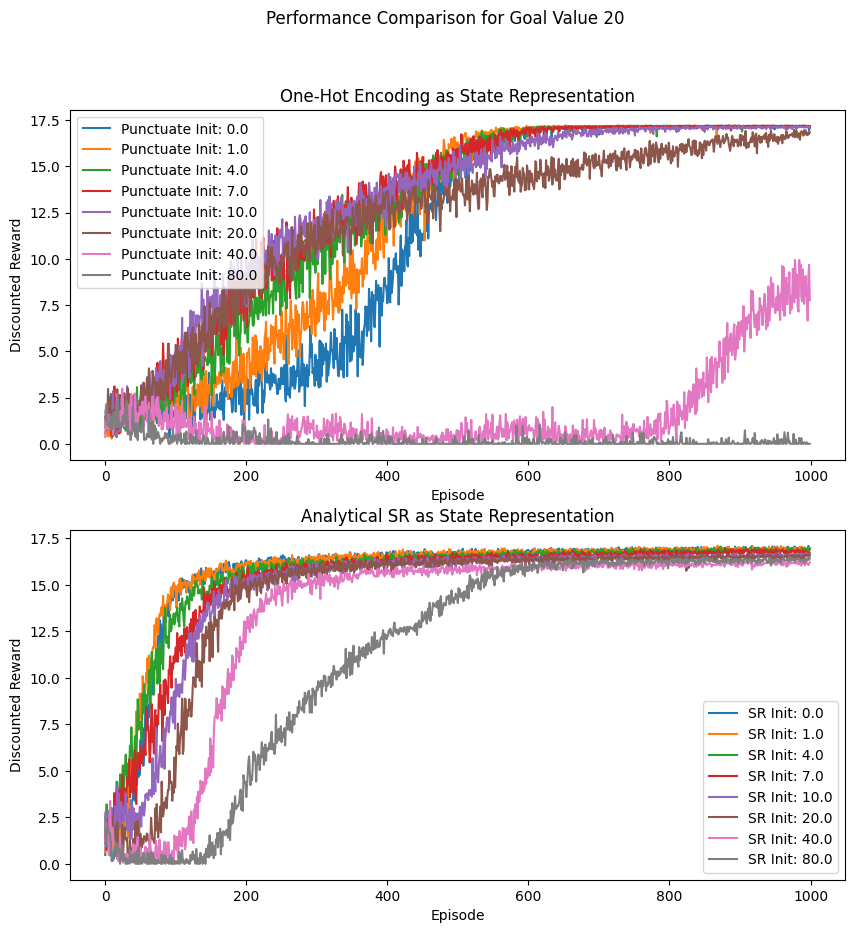

In [61]:
# plot the different initialization
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

for i, init in enumerate(intializations):
    axs[0].plot(earned_mean_rewards_punctuate[i], label='Punctuate Init: {}'.format(init[0]))
    axs[0].legend()
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Discounted Reward')
    axs[0].set_title('One-Hot Encoding as State Representation')
    axs[1].plot(earned_mean_rewards_sr[i], label='SR Init: {}'.format(init[0])) 
    axs[1].legend()
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Discounted Reward')
    axs[1].set_title('Analytical SR as State Representation')
fig.suptitle('Performance Comparison for Goal Value 20');

With a goal value as 20, all initializations larger than 0 and smaller or equal to 20 help speed up learning, while intializations larger than 20 are much worse for learning for One-Hot encoding case.

In the case of successor representation, larger initializations slows down convergence since incorrect values are accumulated quickly due to larger weights which have to be decremented, taking more steps.